# A movie Recommendation System Using MovieLens Data

**Project Overview**

This project focuses on analyzing movie ratings from the MovieLens dataset to provide tailored movie recommendations. It combines collaborative filtering and content-based filtering, to identify the top 5 movies most suited to a user's interests. This dual approach enhances the recommendation accuracy by integrating both user-driven insights and movie-specific characteristics, creating a robust, personalized viewing experience.

**Business Understanding**

In today’s digital age, online streaming platforms such as Netflix, Showmax,HBO,provide a vast library of movies across various genres, which users can stream on devices like smartphones, tablets, smart TVs, and computers. These platforms generate vast amounts of data on user interactions, including viewing habits, preferences, and ratings. However, the challenge lies in leveraging this data to enhance user engagement by providing personalized movie recommendations that align with individual tastes. 

Personalization has a proven impact on engagement; for example, [75% of what people watch on Netflix](https://litslink.com/blog/all-about-netflix-artificial-intelligence-the-truth-behind-personalized-content) comes from its personalized recommendations, highlighting the importance of robust recommendation algorithms in guiding users toward their next favorite show or movie. The goal of this project is to improve user satisfaction and retention by suggesting the top 5 movies a user is likely to enjoy, utilizing a blend of collaborative and content-based filtering.

**Problem Statement**

With the increasing volume of movies available on streaming platforms, users often experience choice overload, making it difficult to discover content that matches their preferences. This reduces user satisfaction and engagement, negatively impacting retention rates for content providers. The challenge is to develop a personalized recommendation system that can accurately predict and suggest movies tailored to individual users' tastes. 

**Objectives**

1. To identify the top 10 most popular genres based on user ratings.
2. To identify if there is a relationship between movie genres and ratings.
3. To examine user-generated tags to identify popular keywords associated with genres and movie themes.
4. To build a recommendation system that suggests the top 5 rated movies to a user.

**Success Metrics**

**Data Understanding**

The [dataset](https://grouplens.org/datasets/movielens/latest/) for the analysis is from the GroupLens research lab at the University of Minnesota. It entails 100,000 movie ratings. It entails different csv files



In [1]:
#Importing the necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind,mannwhitneyu
from sklearn.preprocessing import LabelEncoder
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

## Loading  Data

In [2]:
#loading the csv files
from Functions import load_data

#Defining the csv file paths 
movie_file_path = "Data/movies.csv"
rating_file_path= "Data/ratings.csv"
tags_file_path= "Data/tags.csv"

In [3]:
#Importing functions from the .py file
from Functions import explore_data

#Loading and inspecting the movie csv file
movie_df = pd.read_csv(movie_file_path)  
explore_data(movie_df)

displaying the first 5 rows 
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

Shape of the dataset:  (9742, 3) 

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memo

In [4]:
#Loading and inspecting the movie ratings csv file
rating_df = pd.read_csv(rating_file_path)  
explore_data(rating_df)

displaying the first 5 rows 
    userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931 

Shape of the dataset:  (100836, 4) 

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Statistical summary:
               userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+0

In [5]:
#Loading and inspecting movie tags csv
tags_df = pd.read_csv(tags_file_path)  
explore_data(tags_df)

displaying the first 5 rows 
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200 

Shape of the dataset:  (3683, 4) 

Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Statistical summary:
             userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000    

## Data Cleaning

This section will involve checking the following about the dataset.
- Accuracy
- Validity
- Completeness
- Uniformity

**1. Accuracy**

In [7]:
#Check for duplicates
from Functions import check_and_remove_duplicates
# Checking and removing duplicates in movies dataset
movie_df = check_and_remove_duplicates(movie_df)

# Checking and removing duplicates in ratings dataset
rating_df = check_and_remove_duplicates(rating_df)

# Checking and removing duplicates in tags dataset
tags_df = check_and_remove_duplicates(tags_df)


Number of duplicate rows: 0
No duplicates found.
Number of duplicate rows: 0
No duplicates found.
Number of duplicate rows: 0
No duplicates found.


After running the check on all three datasets (movies, ratings, and tags), we confirm that no duplicate rows were found in any of the datasets. Therefore, the data is clean in this regard and requires no further action to remove duplicates, ensuring the integrity of the subsequent analysis.

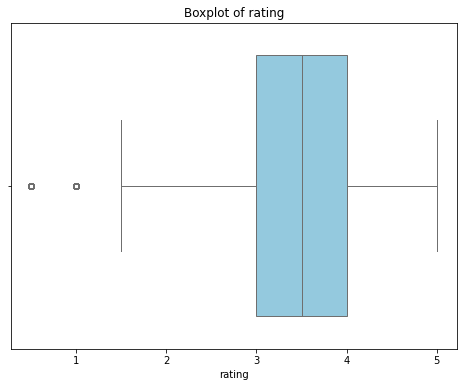

In [8]:
#Checking for outliers in the 'rating' column of the ratings dataset
from Functions import visualize_outliers_with_boxplot
visualize_outliers_with_boxplot(rating_df, 'rating')

The boxplot of the rating column shows that most ratings fall between 3.0 and 4.5, indicating a general preference for higher-rated movies, with a few low outliers reflecting strong dislikes.These outliers are retained because they provide meaningful insights into user behavior, particularly reflecting strong negative opinions about certain movies. Low ratings are critical for understanding user dislikes, which is essential for preventing the recommendation system from suggesting unsuitable movies. By maintaining these outliers, the recommendation system can better capture the diversity of user sentiments, leading to more robust and personalized recommendations that accurately represent the full spectrum of user preferences.


**2.Validity**

In [9]:
#Check for consistency in datatypes
#Timestamp into DATE format

#Converting the timestamp into date format
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])
tags_df['timestamp']= pd.to_datetime(tags_df['timestamp'])  


#Extracting the date

rating_df['timestamp'] = rating_df['timestamp'].dt.date
tags_df['timestamp']=tags_df['timestamp'].dt.date
tags_df['timestamp']
rating_df['timestamp']

0         1970-01-01
1         1970-01-01
2         1970-01-01
3         1970-01-01
4         1970-01-01
             ...    
100831    1970-01-01
100832    1970-01-01
100833    1970-01-01
100834    1970-01-01
100835    1970-01-01
Name: timestamp, Length: 100836, dtype: object

In [10]:
#Checking for unique values in the date column for the rating csv
rating_df['timestamp'].value_counts()

1970-01-01    100836
Name: timestamp, dtype: int64

In [11]:
#Checking for unique values in the date column for the tags csv
tags_df['timestamp'].value_counts()

1970-01-01    3683
Name: timestamp, dtype: int64

Since the timestamp column only indicates the time when users rated a movie and all values fall within the same year (1970), it does not add valuable information to our analysis. Therefore, we will drop it from the dataset to streamline our data and focus on more relevant features.

In [12]:
#Drop irrelevant columns
#Dropping the timestamp column
rating_df=rating_df.drop('timestamp',axis=1)
tags_df=tags_df.drop('timestamp',axis=1)

In [13]:
#Confirm the column names after dropping timestamp
rating_df.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [14]:
#Confirm the column names after dropping the timestamp column
tags_df.columns

Index(['userId', 'movieId', 'tag'], dtype='object')

In [15]:
#Checking for column names
""" The column names are consistent in naming for all files. They are also all in lower case."""

' The column names are consistent in naming for all files. They are also all in lower case.'

**3.Completeness**

In [16]:
#Impute missing values

**4. Consistency/Uniformity**

In [17]:
#Column names capitalization

In [18]:
#Checking if ratings lie within the same range

In [21]:
# Splitting the movie titles from the years
movie_df["Release_year"] = movie_df["title"].apply( lambda x: x[-5:-1] if x[-5:-1].isdigit() else "0000")
movie_df["Release_year"] = movie_df["Release_year"].astype("int64")
movie_df["Release_year"]

0        1995
1        1995
2        1995
3        1995
4        1995
         ... 
22079    2017
22080    2017
22081    2018
22082    2018
22083    1991
Name: Release_year, Length: 22084, dtype: int64

In [22]:
movie_df["genres"].unique()

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'], dtype=object)

Most movies seem to be a **combination of multiple genres** hence why there are so so many unique combinations.

Let's seperate these combinations into individual genres and get more granular data

In [23]:
# seperate the combinations into individual genres by removing the "," seperators
movie_df['genres'] = movie_df['genres'].str.split('|')

# create a new Exploded dataframe with the list of genres into individual rows
movie_df= movie_df.explode('genres').reset_index(drop=True)


movie_df.head()

,movieId,title,genres,Release_year
0,1,Toy Story (1995),Adventure,1995
1,1,Toy Story (1995),Animation,1995
2,1,Toy Story (1995),Children,1995
3,1,Toy Story (1995),Comedy,1995
4,1,Toy Story (1995),Fantasy,1995


The genres column is now made up of lists of individual genres.

**Merging the movie_df with rating_df** 

In [25]:
merged_df=pd.merge(rating_df,movie_df, on='movieId')
merged_df

,userId,movieId,rating,title,genres,Release_year
0,1,1,4.0,Toy Story (1995),Adventure,1995
1,1,1,4.0,Toy Story (1995),Animation,1995
2,1,1,4.0,Toy Story (1995),Children,1995
3,1,1,4.0,Toy Story (1995),Comedy,1995
4,1,1,4.0,Toy Story (1995),Fantasy,1995
...,...,...,...,...,...,...
274475,610,160836,3.0,Hazard (2005),Drama,2005
274476,610,160836,3.0,Hazard (2005),Thriller,2005
274477,610,163937,3.5,Blair Witch (2016),Horror,2016
274478,610,163937,3.5,Blair Witch (2016),Thriller,2016


In [27]:
explore_data(merged_df)

displaying the first 5 rows 
    userId  movieId  rating             title     genres  Release_year
0       1        1     4.0  Toy Story (1995)  Adventure          1995
1       1        1     4.0  Toy Story (1995)  Animation          1995
2       1        1     4.0  Toy Story (1995)   Children          1995
3       1        1     4.0  Toy Story (1995)     Comedy          1995
4       1        1     4.0  Toy Story (1995)    Fantasy          1995 

Shape of the dataset:  (274480, 6) 

Dataset info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274480 entries, 0 to 274479
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   userId        274480 non-null  int64  
 1   movieId       274480 non-null  int64  
 2   rating        274480 non-null  float64
 3   title         274480 non-null  object 
 4   genres        274480 non-null  object 
 5   Release_year  274480 non-null  int64  
dtypes: float64(1), int64(3), obje

## Exploratory Data Analysis

In [ ]:
1. To identify the top 10 most popular genres based on user ratings.
2. To identify if there is a relationship between movie genres and ratings.

**Reference**

1. Rashevskaya, A. (2024, April 12). All about Netflix artificial intelligence: The truth behind personalized content. Litslink. https://litslink.com/blog/all-about-netflix-artificial-intelligence-the-truth-behind-personalized-content